In [1213]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
pd.options.plotting.backend = 'matplotlib' # add small interactivity to the plot
import plotly.express as px 
import seaborn as sns
from factor_analyzer import FactorAnalyzer # this will be used for factor analysis later when working with latent variables

# Linear Regression imports
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ridge Regression imports 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore future version warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning)) # ignore SettingWithCopyWarning

In [1214]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [1215]:
#   combine datasets, they are same layout so concat will work
df = pd.concat([train, test], ignore_index=True)
print(f"Shape of the DataSet: {df.shape}")
df.head()

Shape of the DataSet: (39030, 80)


,UID,BLOCKID,SUMLEVEL,COUNTYID,STATEID,state,state_ab,city,place,type,...,female_age_mean,female_age_median,female_age_stdev,female_age_sample_weight,female_age_samples,pct_own,married,married_snp,separated,divorced
0,267822,NaN,140,53,36,New York,NY,Hamilton,Hamilton,City,...,44.48629,45.33333,22.51276,685.33845,2618.0,0.79046,0.57851,0.01882,0.01240,0.08770
1,246444,NaN,140,141,18,Indiana,IN,South Bend,Roseland,City,...,36.48391,37.58333,23.43353,267.23367,1284.0,0.52483,0.34886,0.01426,0.01426,0.09030
2,245683,NaN,140,63,18,Indiana,IN,Danville,Danville,City,...,42.15810,42.83333,23.94119,707.01963,3238.0,0.85331,0.64745,0.02830,0.01607,0.10657
3,279653,NaN,140,127,72,Puerto Rico,PR,San Juan,Guaynabo,Urban,...,47.77526,50.58333,24.32015,362.20193,1559.0,0.65037,0.47257,0.02021,0.02021,0.10106
4,247218,NaN,140,161,20,Kansas,KS,Manhattan,Manhattan City,City,...,24.17693,21.58333,11.10484,1854.48652,3051.0,0.13046,0.12356,0.00000,0.00000,0.03109


In [1216]:
#   checking uniqueness of UID to determine if it is a Primary Key
is_unique = len(df['UID']) == len(set(df['UID']))
print(f"Is 'UID' unique?: {is_unique}")

#   checking for null values
has_null = df['UID'].isnull().any()
print(f"Does 'UID' have null values?: {has_null}")

#   check how many UID values are not unique
repeat_values = len(df['UID']) - len(set(df['UID']))
print(f"Number of repeat 'UID' values: {repeat_values} ")

Is 'UID' unique?: False
Does 'UID' have null values?: False
Number of repeat 'UID' values: 315 


In [1217]:
duplicated_rows = df[df.duplicated(subset='UID', keep=False)]
print(duplicated_rows.iloc[:,:5]) # for the sake of readability, limit to 5 columns. Cell below will allow the user to look up duplicated rows

          UID  BLOCKID  SUMLEVEL  COUNTYID  STATEID
340    292484      NaN       140        25       55
356    230339      NaN       140        75        6
373    222470      NaN       140        11        4
406    290217      NaN       140       670       51
646    266327      NaN       140         5       36
...       ...      ...       ...       ...      ...
38674  230339      NaN       140        75        6
38696  279172      NaN       140        33       72
38864  267675      NaN       140        47       36
38875  288512      NaN       140        35       49
38882  275715      NaN       140         3       42

[564 rows x 5 columns]


In [1218]:
#   provide a means to look at each duplicated value via Input
rows_with_uid = df.loc[df['UID'] == int(input('Row based on UID to look up'))]
print(rows_with_uid.iloc[:,:5]) # This will print an empty dataframe if no duplicate is found matching the input. Limit to 5 columns for readability 

Empty DataFrame
Columns: [UID, BLOCKID, SUMLEVEL, COUNTYID, STATEID]
Index: []


In [1219]:
#   drop all duplicated values except for the first occurence
df_no_duplicates = df.drop_duplicates(subset='UID', keep='first', inplace=True)
print(df_no_duplicates)

None


In [1220]:
#   gauge fill rate of variables to determine missing value treatment, with lowest percentage at top, highest at bottom
fill_rate = df.count() / len(df) * 100
print(f"Percentage of variable fill rate: \n{fill_rate.sort_values(ascending=True)}")

Percentage of variable fill rate: 
BLOCKID               0.000000
hc_mean              98.346894
hc_sample_weight     98.346894
hc_samples           98.346894
hc_stdev             98.346894
                       ...    
male_pop            100.000000
female_pop          100.000000
universe_samples    100.000000
primary             100.000000
UID                 100.000000
Length: 80, dtype: float64


Treatment of missing values

In [1221]:
#   ensure every value in Primary is 'tract'
tract_count = df[df['primary'] == 'tract'].shape[0]
print(f"{tract_count} out of {df.shape[0]}")

# No places are of Primary type Block, so the column is not needed
df.drop('BLOCKID', axis=1, inplace=True)
print('BLOCKID Dropped')

38715 out of 38715
BLOCKID Dropped


In [1222]:
#   similar to the cell above, check if SUMLEVEL is the same value throughout the entire dataset
sum_level_count = df[df['SUMLEVEL'] == 140].shape[0]
print(f"{sum_level_count} out of {df.shape[0]}")

# SUMLEVEL is same value throughout. Also is not present in the data dictionary, making it droppable.
df.drop('SUMLEVEL', axis=1, inplace=True)
print('SUMLEVEL Dropped')

38715 out of 38715
SUMLEVEL Dropped


In [1223]:
#   fill all null values with the mean of their respective columns. ensure only numeric columns are factored
df.fillna(df.mean(numeric_only=True), inplace=True)
print("Numeric columns mean imputed")

#   check for any non-numeric null values
df.select_dtypes(exclude='number').isna().sum().sum()

Numeric columns mean imputed


0

Debt Analysis: Top 2,500 locations where the percentage of households with a second 
mortgage is the highest and percent ownership is above 10 percent. Visualize using 
geo-map. Keep the upper limit for the percent of households with a second 
mortgage to 50 percent.

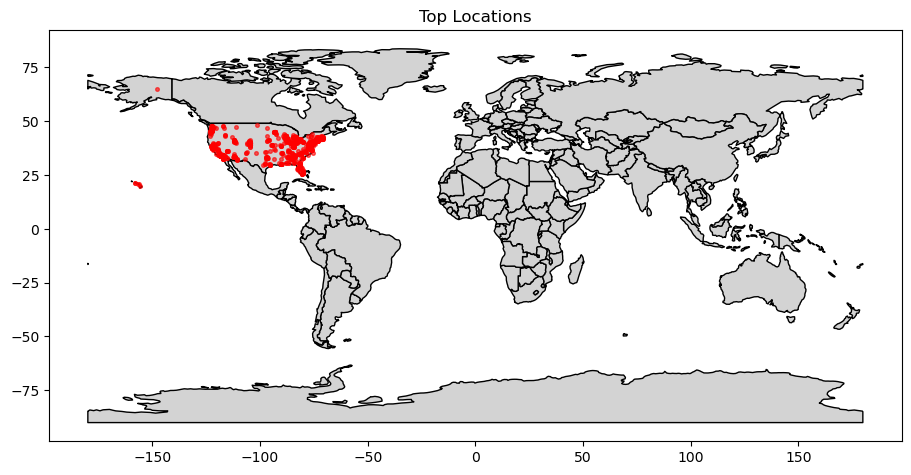

In [1224]:
#  find the rows where Second Mortgage is between 10 and 50 percent, and Percent Own is greater than 10 percent
filtered_data = df[(df['second_mortgage'].between(.10, .50)) & (df['pct_own'] > .10)]

# sort and select top locations
top_locations = filtered_data.sort_values(by='second_mortgage', ascending=False).head(2500)

# assign geopanda variables
geometry = [Point(xy) for xy in zip(filtered_data['lng'], filtered_data['lat'])]
gdf = gpd.GeoDataFrame(filtered_data, geometry=geometry)

# plot the GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(11, 6), color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, color='red', marker='o', markersize=7, alpha=0.6)
plt.title('Top Locations')
plt.show()

In [1225]:
# Bad Debt = P (Second Mortgage ∩ Home Equity Loan)
df['bad_debt'] = df['second_mortgage'] + df['home_equity'] - df['home_equity_second_mortgage']
df['overall_debt'] = df['second_mortgage'] + df['home_equity']

In [1226]:
#  slightly interactive graph that allows for viewing of value totals. 
#   NOTE TO SELF: GitHub does not currently seem to support Plotly graphs without certain intervention. Works fine in IDE, need a solution for GitHub
#   for now, will create a non-interactive one below this cell for GitHub compatability
pie_data = pd.DataFrame({
    'Category': ['Overall Debt', 'Bad Debt'],
    'Value': [df['overall_debt'].sum(), df['bad_debt'].sum()]
})
fig = px.pie(pie_data, values='Value', names='Category', title='Overall Debt and Bad Debt Pie Chart', width= 400, height= 300)
fig.show()

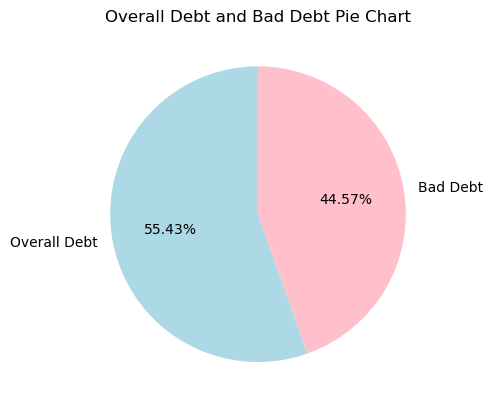

In [1227]:
labels = ['Overall Debt', 'Bad Debt']
values = [df['overall_debt'].sum(), df['bad_debt'].sum()]

# Plotting the pie chart
plt.pie(values, labels=labels, autopct='%1.2f%%', startangle=90, colors=['lightblue', 'pink'])
plt.title('Overall Debt and Bad Debt Pie Chart')
#plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

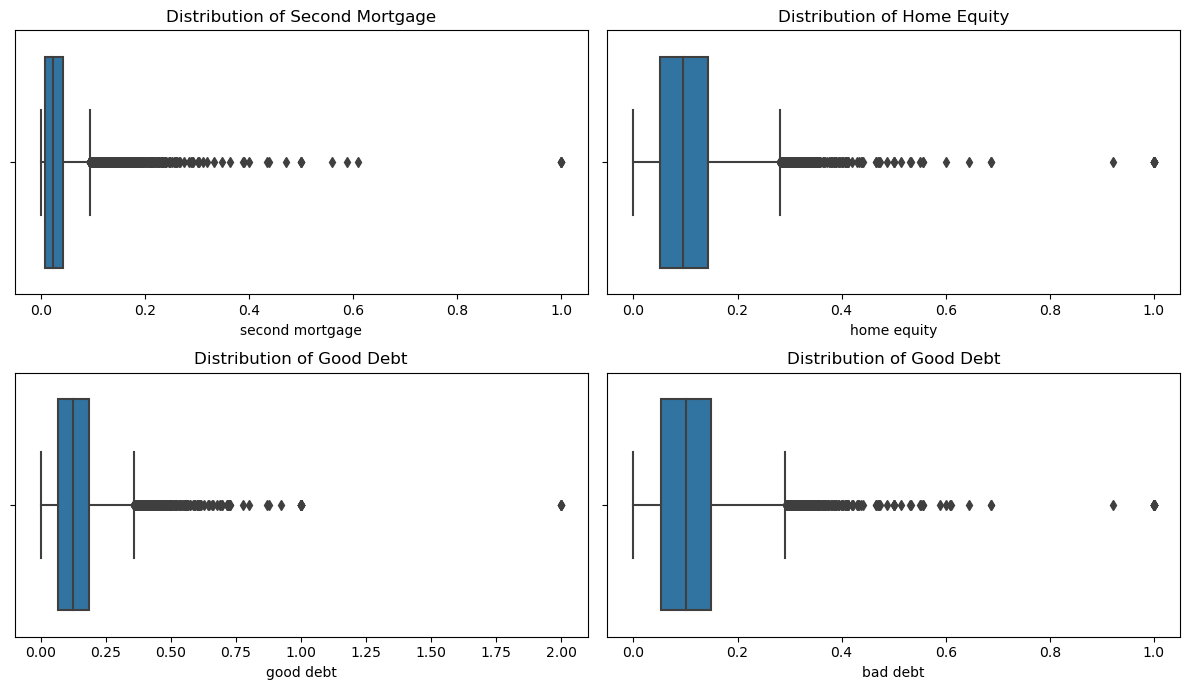

In [1228]:
# Set the size of the plot
plt.figure(figsize=(12, 7))

# Boxplot for Second Mortgage
plt.subplot(2, 2, 1)
sns.boxplot(x='second_mortgage', data=df)
plt.xlabel('second mortgage')
plt.title('Distribution of Second Mortgage')

# Boxplot for Home Equity
plt.subplot(2, 2, 2)
sns.boxplot(x='home_equity', data=df)
plt.xlabel('home equity')
plt.title('Distribution of Home Equity')

# Boxplot for Good Debt
plt.subplot(2, 2, 3)
sns.boxplot(x='overall_debt', data=df)
plt.xlabel('good debt')
plt.title('Distribution of Good Debt')

# Boxplot for Bad Debt
plt.subplot(2, 2, 4)
sns.boxplot(x='bad_debt', data=df)
plt.xlabel('bad debt')
plt.title('Distribution of Good Debt')

plt.tight_layout()
plt.show()

Collated Income Distribution Chart

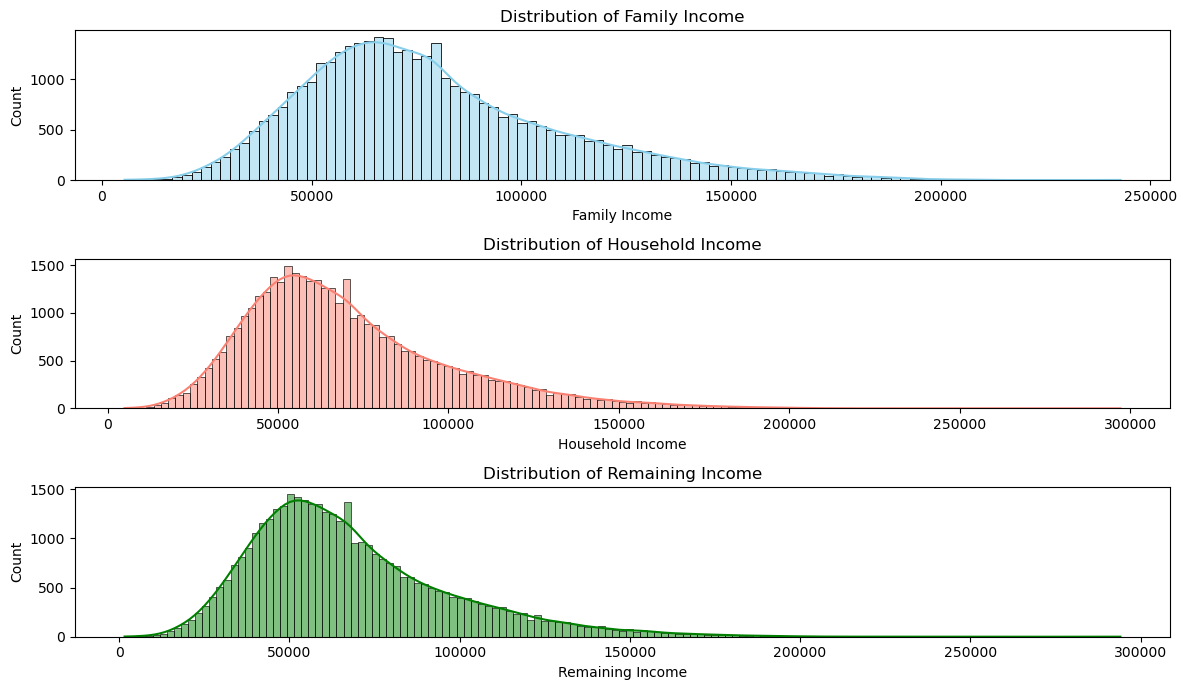

In [1229]:
'''   create Remaining Income column. FORMULA: Household Income - (Rent Mean + Monthly Mortgage and Owner Costs Mean)
 NOTE: this dataset only gives us access to housing information, so other basic neccessities are not accounted for in the formula  '''
df['remaining_income'] = df['hi_mean'] - (df['rent_mean'] + df['hc_mortgage_mean'])

plt.figure(figsize=(12, 7))

# Plot the distribution of Family Income, including kde for each plot
plt.subplot(3, 1, 1)
sns.histplot(df['family_mean'], kde=True, color='skyblue')
plt.xlabel('Family Income')
plt.title('Distribution of Family Income')

# Plot the distribution of Household Income
plt.subplot(3, 1, 2)
sns.histplot(df['hi_mean'], kde=True, color='salmon')
plt.xlabel('Household Income')
plt.title('Distribution of Household Income')

# Plot the distribution of Remaining Income
plt.subplot(3, 1, 3)
sns.histplot(df['remaining_income'], kde=True, color='green')
plt.xlabel('Remaining Income')
plt.title('Distribution of Remaining Income')

plt.tight_layout()

Perform EDA and come out with insights into population density and age

In [1230]:
# create new columns pop_density and median_age (male and female)
df['population_density'] = df['pop'] / df['ALand']
# weight the new median age column
df['median_age'] = (df['male_age_median'] * df['male_pop'] * df['male_age_sample_weight'] +
                    df['female_age_median'] * df['female_pop'] * df['female_age_sample_weight']) / \
                   (df['male_pop'] * df['male_age_sample_weight'] + df['female_pop'] * df['female_age_sample_weight'])

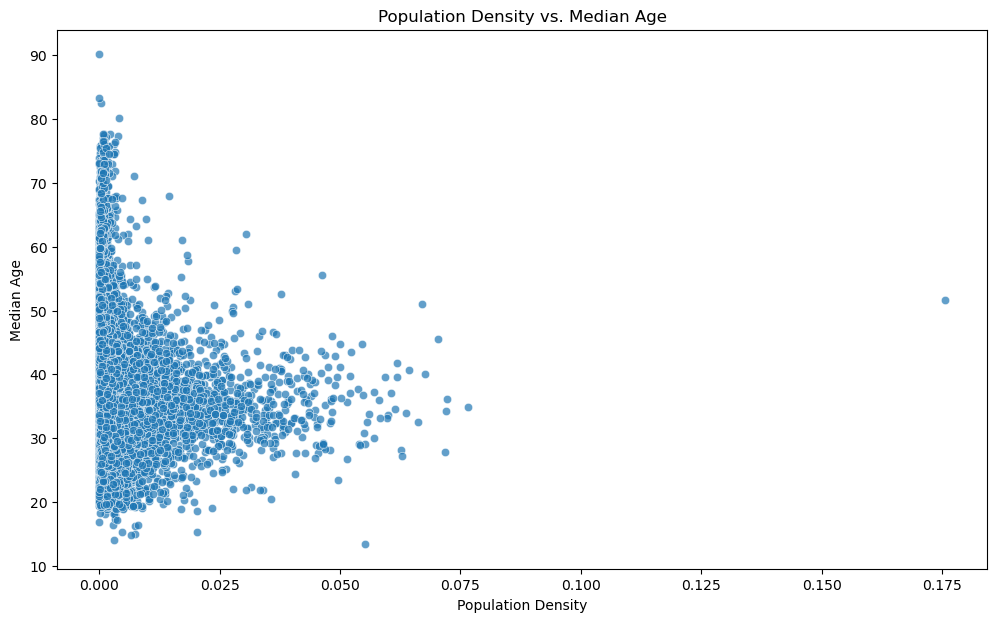

In [1231]:
# plot the pop density vs median age via a scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(x='population_density', y='median_age', data=df, alpha=0.7)
plt.title('Population Density vs. Median Age')
plt.xlabel('Population Density')
plt.ylabel('Median Age')
plt.show()

Create 5 interval bins for population 

In [1232]:
bin_edges = [0, 1000, 2000, 3000, 4000, float('inf')]

#   define bin labels
bin_labels = ['0-1k', '1k-2k', '2k-3k', '3k-4k', '4k+']

#   create a new variable 'population_bins'
df['population_bins'] = pd.cut(df['pop'], bins=bin_edges, labels=bin_labels, include_lowest=True)

#   display the DataFrame with the new variable
print(df[['pop', 'population_bins']].head())

    pop population_bins
0  5230             4k+
1  2633           2k-3k
2  6881             4k+
3  2700           2k-3k
4  5637             4k+


Analyze the married, separated, and divorced population for the population brackets

In [1233]:
marital_status_summary = df.groupby('population_bins')[['married', 'separated', 'divorced']].sum()
print(marital_status_summary)

                     married   separated     divorced
population_bins                                      
0-1k               250.08479   14.803444    62.003282
1k-2k             1402.32403   71.899120   348.204610
2k-3k             3284.66443  136.475450   736.889470
3k-4k             4235.27192  160.302690   857.506110
4k+              10521.72846  356.517720  1871.171440


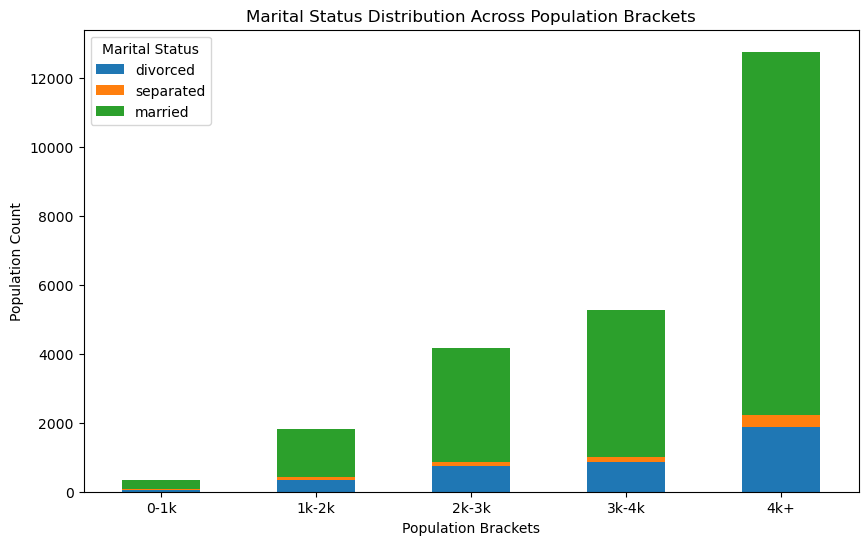

In [1234]:
# reverse the order of columns to invert the stacking order (so that the greater value "married" is on top)
marital_status_chart = marital_status_summary[['divorced', 'separated', 'married']]

# plotting with inverted stacking order
ax = marital_status_chart.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Marital Status Distribution Across Population Brackets')
plt.xlabel('Population Brackets')
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, ha='center') # the space is wide enough to support a flat axis label
plt.ylabel('Population Count')
plt.legend(title='Marital Status', loc='upper left')
plt.show()

Observations for Rent as a percentage of Income at an Overall and State level

In [1235]:
#   create rent_percentage column using median (minimize the skewness)
df['rent_percentage'] = (df['rent_median'] / df['hi_median']) * 100

#   OVERALL rent to income percentage
overall_stats = df['rent_percentage'].describe()
state_stats = df['rent_percentage']
print("Overall Observations:")
print(overall_stats)

#   STATE grouped rent to income percentage
state_stats = df.groupby('state')['rent_percentage'].describe()
print("\nState-Level Observations:")
print(state_stats.head()) #Limit to five rows printed

Overall Observations:
count    38715.000000
mean         1.944790
std          0.815024
min          0.144874
25%          1.440635
50%          1.794239
75%          2.273535
max         37.181628
Name: rent_percentage, dtype: float64

State-Level Observations:
             count      mean       std       min       25%       50%  \
state                                                                  
Alabama      612.0  1.876535  0.726146  0.274948  1.420325  1.707687   
Alaska       105.0  1.707308  0.518242  0.891836  1.389673  1.602790   
Arizona      790.0  2.081644  0.789631  0.559795  1.683732  1.972864   
Arkansas     361.0  1.779026  0.580156  0.562306  1.412693  1.659298   
California  4150.0  2.295640  0.730147  0.396305  1.830510  2.190651   

                 75%        max  
state                            
Alabama     2.128067   8.016444  
Alaska      1.895086   3.737969  
Arizona     2.366167  15.910645  
Arkansas    2.019614   4.122264  
California  2.651018  12.466

Perform correlation analysis for all the relevant variables via Heatmap

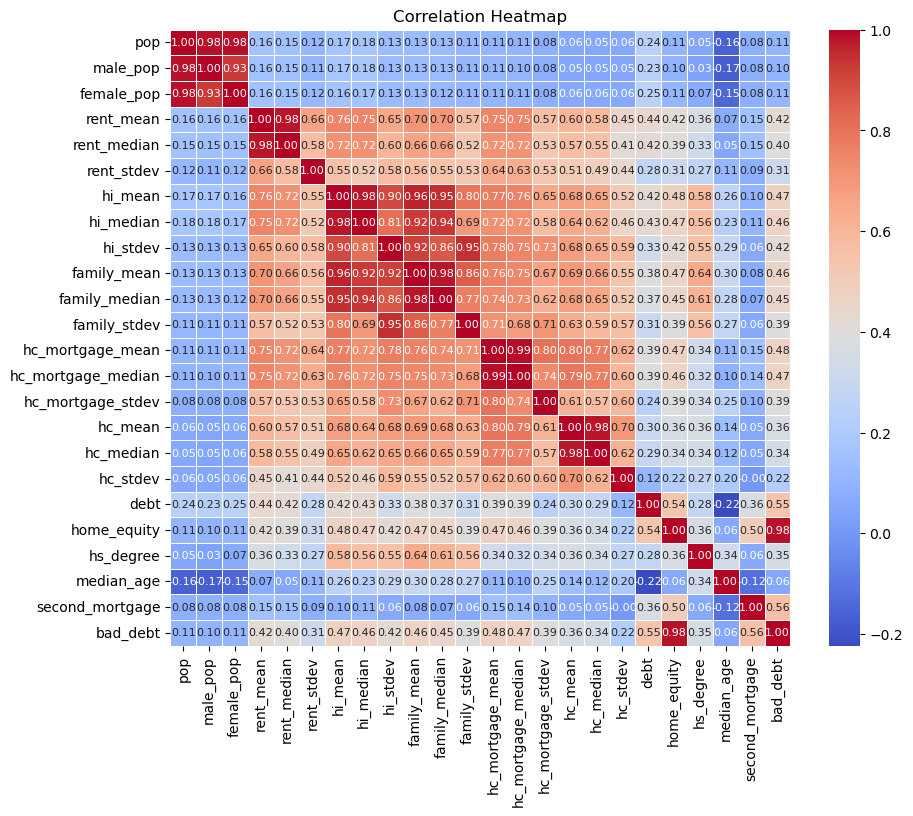

In [1236]:
#   create a list that includes relevant, numeric columns only
numeric_columns = [
    'pop', 'male_pop', 'female_pop', 'rent_mean', 'rent_median', 'rent_stdev', 
    'hi_mean', 'hi_median', 'hi_stdev', 'family_mean', 'family_median', 'family_stdev',
    'hc_mortgage_mean', 'hc_mortgage_median', 'hc_mortgage_stdev', 'hc_mean', 'hc_median', 'hc_stdev', 'debt', 'home_equity',
    'hs_degree', 'median_age', 'second_mortgage', 'bad_debt' ]
numeric_df = df[numeric_columns]
correlation_matrix = numeric_df.corr()

#   create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, annot_kws={"size": 8})
plt.title('Correlation Heatmap')
plt.show()

Quick observations: as expected, Debt has a considerable amount of correlation (0.54) with home_equity, which are two very important factors when considering Mortgage Backed Securities. With the next highest correlation for debt being rent_mean. Household Income and Family Income are highly correlated across the board, no surprise there, but definitely should be accounted for regardless. 



The economic multivariate data has a significant number of measured variables.
The goal is to find where the measured variables depend on a number of smaller unobserved common factors or latent variables. 
Use factor analysis to find latent variables in the dataset and gain insight into the linear 
relationships in the data.

In [1237]:
#   fill NaN values in Median_age with the median
df['median_age'].fillna(df['median_age'].median(), inplace=True)
print(df.isna().sum().sum())

0


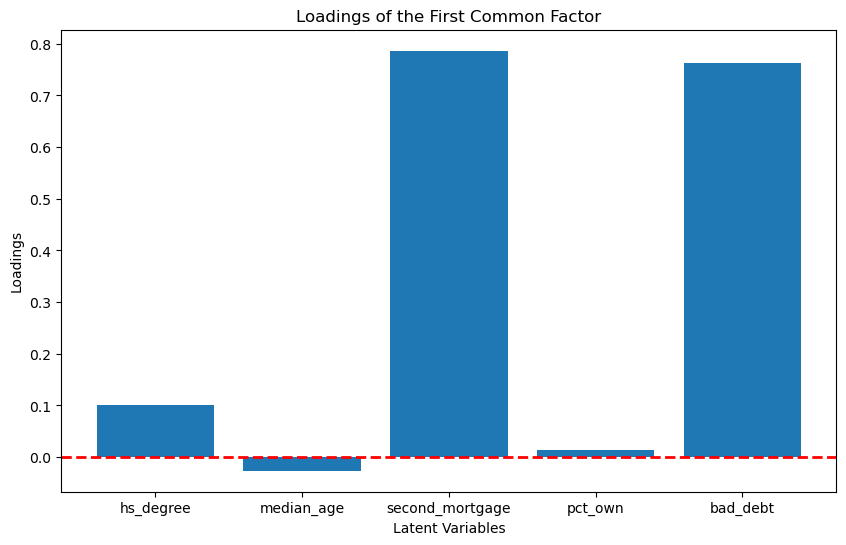

In [1238]:
latent_variables = ['hs_degree', 'median_age', 'second_mortgage', 'pct_own', 'bad_debt']

#   create a variable that pulls the selected columns from the list
latent_data = df[latent_variables] 
latent_data.dropna(inplace=True)

#   perform factor analysis
factor_model = FactorAnalyzer(n_factors=len(latent_variables), rotation='oblimin') # change rotation to oblimin for support with singular matrix
factor_model.fit(latent_data)

#   obtain common factors and loadings
common_factors = factor_model.transform(latent_data)
loadings = factor_model.loadings_

# Plot the loadings
plt.figure(figsize=(10, 6))
plt.bar(latent_variables, loadings[:, 0])  # plot loadings for the first common factor
plt.axhline(0, color='red', linestyle='--', linewidth=2) # Q.O.L. addition, adding a line for the zero Y-axis
plt.xlabel('Latent Variables')
plt.ylabel('Loadings')
plt.title('Loadings of the First Common Factor')
plt.show()

Build a Linear Regression model to predict the total monthly expenditure for home mortgages loan. PREDICTED VARIABLE = hc_mortgage_mean. This is the mean monthly mortgage and owner costs of specified geographical location

<AxesSubplot:>

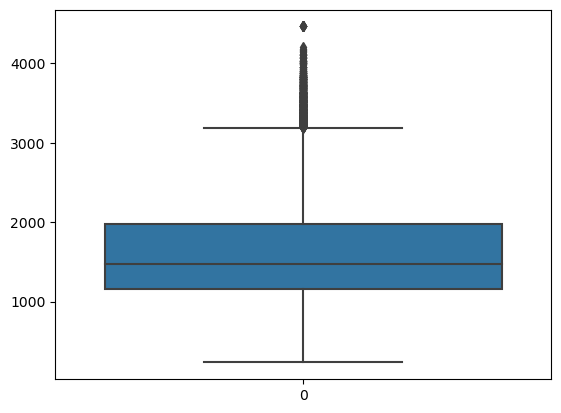

In [1239]:
#   check the spread of target variable
sns.boxplot(df['hc_mortgage_mean'])

In [1240]:
#   thanks to the boxplot, we can see there are several outliers.
#   run a quantile test to find the exact limits
upper_limit = df['hc_mortgage_mean'].quantile(0.99)
lower_limit = df['hc_mortgage_mean'].quantile(0.01)
print('Upper limit is:', upper_limit)
print('lower limit is:', lower_limit)

Upper limit is: 3464.316895000001
lower limit is: 756.31606


In [1241]:
#   convert the outliers to make them equal to the quantile limit closest to them. This will help mitigate extreme outliers
#   EXAMPLE: anything below 756.099 = convert to 756.099. Anything above 3464.826 = convert to 3464.826
df['hc_mortgage_mean'] = np.where(df['hc_mortgage_mean'] < lower_limit, lower_limit, df['hc_mortgage_mean'])
df['hc_mortgage_mean'] = np.where(df['hc_mortgage_mean'] > upper_limit, upper_limit, df['hc_mortgage_mean'])

#   ensure the min and max are working as intended now
df['hc_mortgage_mean'].describe()

count    38715.000000
mean      1629.539413
std        612.196885
min        756.316060
25%       1160.449070
50%       1471.993770
75%       1972.283630
max       3464.316895
Name: hc_mortgage_mean, dtype: float64

In [1242]:
#   create the list of columns the model will use for Predictors 
OLS_numeric_columns = [
    'rent_mean', 'hi_mean', 'hc_mean', 'debt', 
    'home_equity', 'second_mortgage', 'hs_degree']

#   check for Variance Inflation in the Predictors
x = df[OLS_numeric_columns]
vif_data = pd.DataFrame()
vif_data['Features'] = x.columns
vif_data['vif'] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]
print(vif_data)

          Features        vif
0        rent_mean  17.468029
1          hi_mean  21.320129
2          hc_mean  13.146280
3             debt  24.720122
4      home_equity   6.031825
5  second_mortgage   2.636825
6        hs_degree  23.435878


In [1243]:
#   create a constant for the model to estimate an intercept term in addition to the coefficients
x_with_constant = sm.add_constant(df[OLS_numeric_columns]) # --> Features
y = df['hc_mortgage_mean'] # --> Target Variable

#   split the test and train data, to later see how they perform in comparison
x_train, x_test, y_train, y_test = train_test_split(x_with_constant, y, random_state=42, test_size=0.25)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

#   initiate the OLS model 
model = sm.OLS(y_train, x_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       hc_mortgage_mean   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                 1.555e+04
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        00:42:01   Log-Likelihood:            -2.0492e+05
No. Observations:               29036   AIC:                         4.099e+05
Df Residuals:                   29028   BIC:                         4.099e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             635.1476     15.199     41.788      0.000     605.356     664.939
rent_mean           0.3968      0.006     64.882      0.000       0.385       0.409
hi_mean             0.0055      0.000     51.208      0.000       0.005       0.006
hc_mean             1.2406      0.010    119.143      0.000       1.220       1.261
debt              -12.2565     13.458     -0.911      0.362     -38.636      14.122
home_equity       980.5375     33.888     28.935      0.000     914.116    1046.959
second_mortgage   116.2631     60.767      1.913      0.056      -2.843     235.370
hs_degree        -674.0277     18.529    -36.377      0.000    -710.345    -637.710
==============================================================================
Omnibus:                     8084.242   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40326.408
Skew:                           1.262   Prob(JB):                         0.00
Kurtosis:                       8.192   Cond. No.                     2.94e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1244]:
#   fit the Regression Model to initiate the Target Variable.
reg = linear_model.LinearRegression()
reg.fit(x_train,y_train)
y_pred_train = reg.predict(x_train)
y_pred_test = reg.predict(x_test)

In [1245]:
#   print the breakdown of the Train Model
print("r square: {}".format(r2_score(y_train, y_pred_train)))
print('MAE: {}'.format(mean_absolute_error(y_train, y_pred_train)))
print("MSE: {} ".format(mean_squared_error(y_train, y_pred_train)))

r square: 0.7895077984980663
MAE: 199.77713838692807
MSE: 79011.0705096383 


In [1246]:
#   print the breakdown of the Test Model
print("r square: {}".format(r2_score(y_test, y_pred_test)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred_test)))
print("MSE: {} ".format(mean_squared_error(y_test, y_pred_test)))

r square: 0.7839914423561725
MAE: 199.49527120641898
MSE: 80556.79315393412 


In [1247]:
#   pull the first five cases and compare Actual to Predicted (for a little extra visualization)
for actual, predicted in zip(y_test[:5], y_pred_test[:5]):
    print(f'Actual: {actual:.2f}, Predicted: {predicted:.2f}')

Actual: 2728.69, Predicted: 2309.15
Actual: 2560.55, Predicted: 2175.27
Actual: 2065.00, Predicted: 1917.60
Actual: 1121.77, Predicted: 1006.22
Actual: 1049.33, Predicted: 1196.75


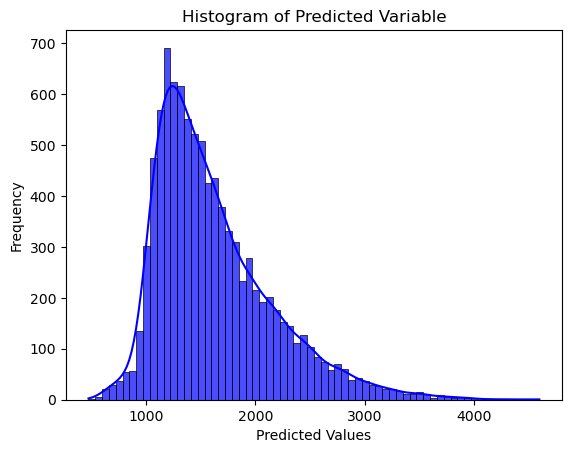

In [1249]:
#   plot the Predicted Variable to ensure it is normally distributed
sns.histplot(y_pred_test, bins='auto', alpha=0.7, color='blue', edgecolor='black', kde=True)
plt.title('Histogram of Predicted Variable')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.show()
#   it is visibly positively skewed, but nothing overly egregious

Next is to create a Tableau Dashboard with the data, which will be linked here when completed